In [115]:
from mazelib import *
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from dataset import *

import random
random.seed(7)

#### Problem definition
    
    Inputs:
        - Maze start and end points
        - Maze (drivable non drivable area) /  not necessary as long the supervision exist
        - Mazes should be generated by difficulty and should be unique
        
    Outputs:
        - x, y future coordinates of the agent (one move)
        - The number of moves to solve the maze is variable
        - A grid is generated using the predicted coordinates and the agent size
    
    Losses:
        - Imitation Loss, RMSE
        - Path planning loss, overlap between predicted ego and desired path planning
        - Maze loss, overlap between predicted ego and maze walls (do not hit or traverse)
        - Start/ end loss: overlap of the FIRST and LAST sequence points with the maze's entrance and exit
        
    Notes:
        - We study the effect of dopping (%) on non-valid trajectories on the agent's behavior
        
        
### Create dataset


In [2]:
me = MazeExplorer(maze_size=(64,64), nbr_instances=10000, difficulty='mixed', nbr_trajectories=15)

  6%|▋         | 105/1666 [00:00<00:01, 1047.65it/s]

Creating MazeExplorer dataset of difficulty mixed
Using Prims generator
Using shortest path solver


100%|██████████| 1666/1666 [00:05<00:00, 282.73it/s]


Dataset generated... 159936 available instances


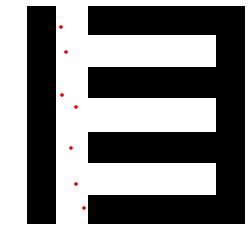

In [3]:
plot_solution(me[232][0], me[232][4])

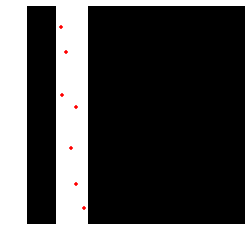

In [4]:
plot_solution(me[232][1], me[232][4])

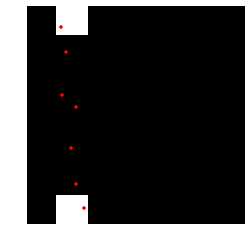

In [5]:
plot_solution(me[232][2], me[232][4])

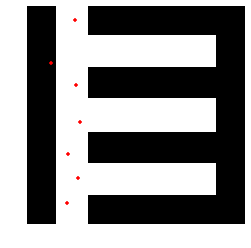

In [6]:
plot_solution(me[233][0], me[233][4])

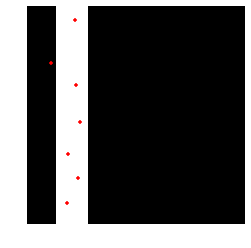

In [7]:
plot_solution(me[233][1], me[233][4])

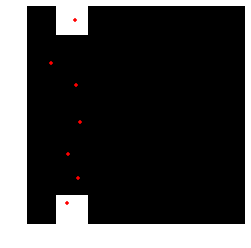

In [8]:
plot_solution(me[233][2], me[233][4])

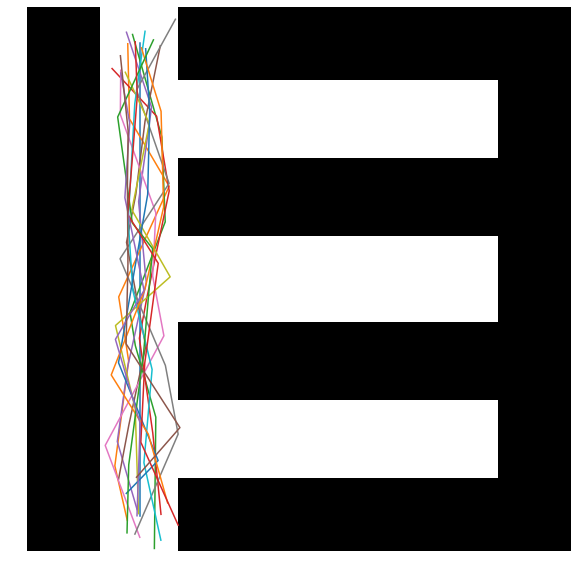

In [9]:
plot_trajectories(me[235][0], me[235][5])

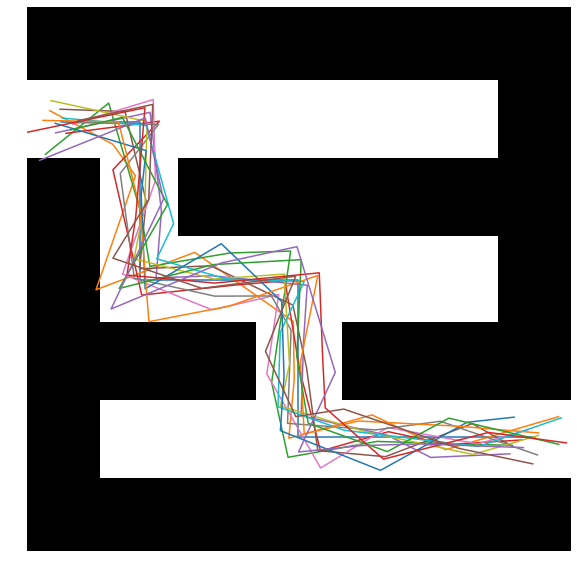

In [10]:
plot_trajectories(me[15000][0], me[15000][5])

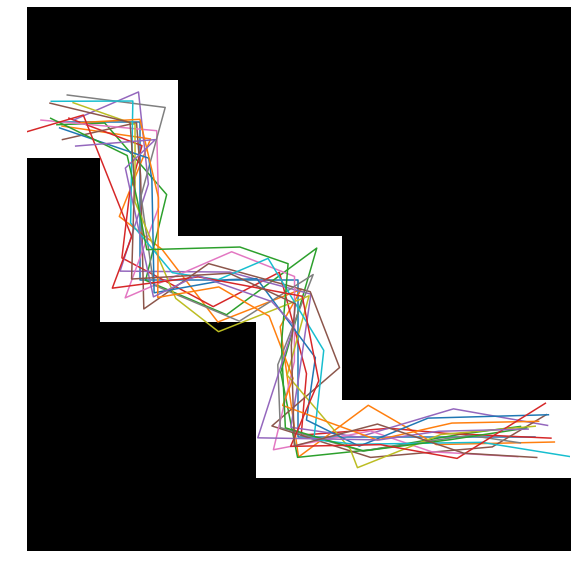

In [11]:
plot_trajectories(me[15000][1], me[15000][5])

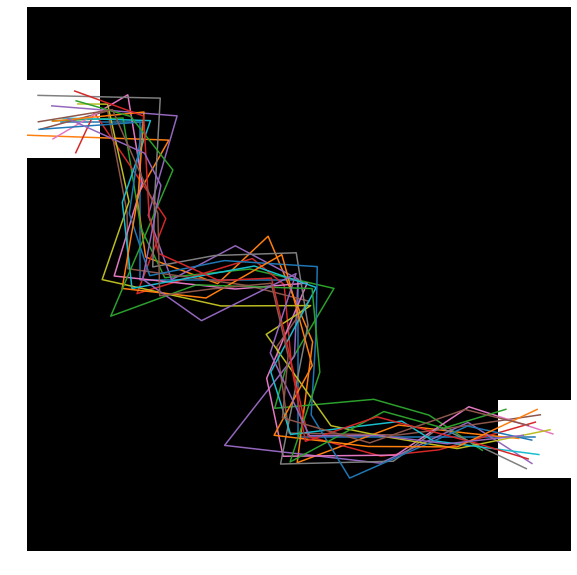

In [12]:
plot_trajectories(me[15000][2], me[15000][5])

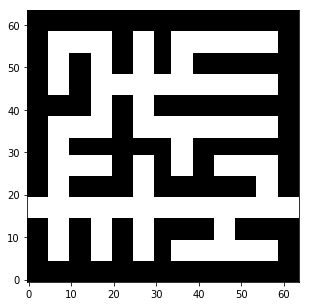

In [32]:
showPNG(me[80000][0], axis=True)

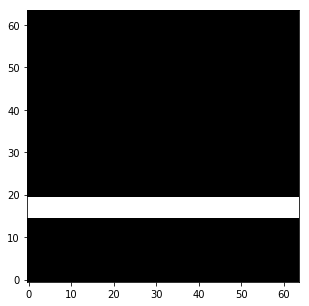

In [31]:
showPNG(me[80000][1], axis=True)

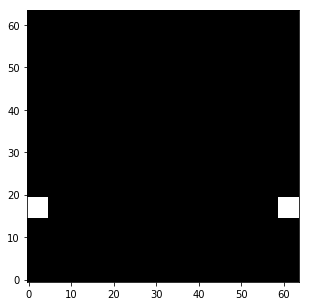

In [30]:
showPNG(me[80000][2], axis=True)

In [309]:
family = generate_family_trajectories(me[80000][5][0], 10, 4)
grid = me[80000][0]
path = me[80000][1]
goal = me[80000][2]
solution = family[0]

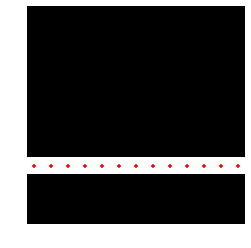

In [92]:
plot_solution(grid, solution)

In [34]:
estimate_road_width(grid)

4

In [35]:
estimate_road_width(path)

4

In [36]:
estimate_road_width(goal)

4

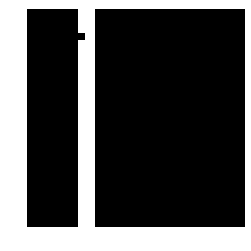

In [120]:
play_raw_data(path, tr, 3)

In [285]:
def play_raw_data2(grid, solution, road_size, canvas_size=64):
    """Plot raw data.

    """
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    l = int(road_size/2)
    w = int(road_size/2)
    for i, pixel in enumerate(solution): 
        #x, y = pixel
        #polygon = polygon_from_ego((x,y),angle=90,l=l,w=w)
        #canvas = np.zeros_like(resize_grid(grid, (64,64)))
        #ego_canvas = draw_egopose(canvas, polygon)
        ego_canvas = predicted_grid(pixel, road_size)
        # grid + canvas
        add = cv2.add(grid.T, ego_canvas)
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.imshow(add, cmap=plt.cm.binary)
        
        time.sleep(1)
        plt.axis('off')
        loss = overlap_loss2(ego_canvas,grid)
        plt.title(loss)
    plt.close()

In [304]:
def check_trajectory(trajectory, grid, road_size):
    '''Check how many points of a given trajectory
    are not consistent with the environment (collision)
    '''
    collision_count = 0
    for i, pixel in enumerate(trajectory): 
        # Get predicted canvas
        ego_canvas = predicted_grid(pixel, road_size, angle=90)
        # Check if ego canvas and environment overlaps
        add = cv2.add(grid.T, ego_canvas)
        
        collisions = np.where(add == 2.)
        if collisions[0].any():  # Overlap detected
            collision_count += 1
            
        return collision_count, len(trajectory)
    

In [305]:
check_trajectory(tr, path, 4)

(0, 13)

In [ ]:
def dopping_percentage():
    '''Estimate number of trajectory points that 
    are not consistent with the environement.
    
    '''

In [286]:
l = int(4/2)
w = int(4/2)
solution = tr

overlaps = []
over_count = 0
no_over_count = 0

for i, pixel in enumerate(solution): 
    x, y = pixel
    polygon = polygon_from_ego((x,y),angle=90,l=l,w=w)
    canvas = np.zeros_like(resize_grid(grid, (64,64)))
    ego_canvas = draw_egopose(canvas, polygon)
    # grid + canvas
    add = cv2.add(grid.T, ego_canvas)
    # Pixel == 2 where agent overlaps
    aux_over = np.where(add == 2.)
    
    if aux_over[0].any():  # Overlap detected
        overlaps.append(aux_over)
        over_count += 1
    else:
        # no overlap detected
        no_over_count += 1 
        

In [307]:
def predicted_grid(prediction, road_size, angle=90, canvas_size=(64,64)):
    # Estimate agents size
    w, l = (int(road_size/2), int(road_size/2))
    x, y = prediction
    # Draw polygon
    polygon = polygon_from_ego((x,y),angle=angle,l=l,w=w)
    canvas = np.zeros(canvas_size)
    pred_grid = draw_egopose(canvas, polygon)
    return pred_grid
     

In [292]:
def overlap_loss2(predicted_grid, grid):
    add = cv2.add(grid.T, predicted_grid)
    # Get overlapping
    overlap = np.where(add == 2.)
    # Compute loss
    ## Number of overlaped pixels: m2 of overlapping ego + env
    if overlap[0].any(): # Overlap exist
        print(overlap)
        loss = len(overlap[0])
    else:  # No overlap
        loss = 0
    ### Shall we add some kind of spatial smooth factor?
    return loss

In [289]:
pred_g = predicted_grid(tr[2], 90, 4)

In [290]:
overlap_loss(pred_g, grid)

0

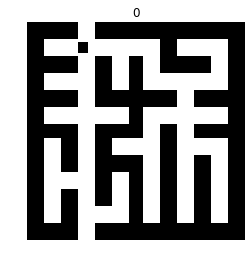

<Figure size 720x720 with 0 Axes>

In [313]:
play_raw_data2(grid, tr, 4)

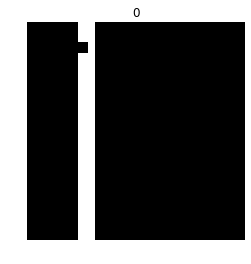

<Figure size 720x720 with 0 Axes>

In [314]:
play_raw_data2(path, tr, 4)

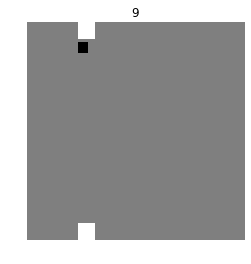

<Figure size 720x720 with 0 Axes>

In [315]:
play_raw_data2(goal, tr, 4)

In [327]:
def check_trajectory2(trajectory, grid, road_size):
    '''Check how many points of a given trajectory
    are not consistent with the environment (collision)
    '''
    collision_count = 0
    for pixel in trajectory:
        # Get predicted canvas
        ego_canvas = predicted_grid(pixel, road_size, angle=90)
        # Check if ego canvas and environment overlaps
        add = cv2.add(grid.T, ego_canvas)
        collisions = np.where(add == 2.)
        if collisions[0].any():  # Overlap detected
            collision_count += 1
            
    return collision_count, len(trajectory)

In [328]:
check_trajectory2(tr, path, 4)

(5, 13)

In [322]:
for pixel in tr:
    print(pixel)

[17.50154807 64.769656  ]
[17.36751787 56.95218816]
[17.62942062 49.19368417]
[16.23962491 46.96323012]
[15.18487624 40.78596169]
[15.90201787 36.2711748 ]
[18.09483078 33.63494347]
[14.95541777 28.73553061]
[18.64043994 22.37943479]
[15.86852841 19.82601422]
[15.8107269  11.64544486]
[16.34321163  7.66107127]
[17.26696512  1.18900605]
